In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

font_options = {'family' : 'monospace'}
figure_options = {'figsize':[8,5]}

plt.rc('font', **font_options) 
plt.rc('figure', **figure_options)

In [2]:
data = pd.read_csv("data/binary_classification.csv")
data.head()

,X1,X2,y
0,0.345211,0.679774,1
1,0.191130,0.551668,0
2,0.358081,0.012984,1
3,0.393526,0.994465,0
4,0.387360,0.941051,0


In [3]:
X = data.iloc[:, :2].values
y = data.y.values[:, np.newaxis]
X.shape, y.shape

((1000, 2), (1000, 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Вероятность принадлежности к классу

$$ P(y = 1 | x, w) = \sigma(x, w) $$

Логистическая функция потерь

$$ L(y, p) = - \frac{1}{m}\sum_{1}^{m}(y_i log(p_i) + (1 - y_i) log(1 - p_i)) $$

## Логистическая регрессия


Выведем функцию связи через биномиальное распределение через задачу классификации:

$y \in \{0,1\}$ 
$$g^{-1}(p) = \overline{\theta}^T \overline{X}$$
$$f(y) = e^{\frac{y\alpha-c(\alpha)}{\varphi}+h(y,\varphi)}$$

Плотность биномиального распределения:
$$f(y) = p^y(1-p)^{1-y} = exp(y\log p + (1-y)\log(1-p)) = exp(y\log\frac{p}{1-p}+\log(1-p)\equiv c(\alpha)$$
$$\alpha  = \log \frac{p}{1-p} = g(p) = \overline{\theta}^T \overline{X}$$
$$\frac{p}{1-p} = e^{\overline{\theta}^T \overline{X}}$$
$$p = \sigma\left(\overline{\theta}^T \overline{X}\right) = \frac{1}{1+e^{-\overline{\theta}^T \overline{X}}}$$

Осталось получить функционал качества для задачи классификации. Функция называется \textsc{логистической сигмоидой}. Данная функция преобразует линейную комбинацию в интервал $[0,1]$. Дальнейшее значение целевой переменной мы будем предсказывать в качестве:
$$\hat{y} = \sigma\left(\overline{\theta}^T \overline{X}\right)$$

Функционал качества найдём через метод максимального правдоподобия:
$$p(x,y,p) = \prod\limits_{i=1}^l p_i^{y_i}(1-p_i)^{1-y_i} \xrightarrow[\theta]{}\max $$
$$\sum\limits_{i=1}^l y_i \log p_i + (1-y_i)\log(1-p_i)  \xrightarrow[\theta]{}\max$$

Функция потерь называется \textsc{LogLoss}:
$$LogLoss = L(x_i) = y_i \log p_i - (1-y_i)\log p_i  \xrightarrow[\theta]{}\min, p_i = \sigma(x_i)$$

Если мы правильно предсказываем отношение принадлежности класса к $1$, то функция потерь будет равна нулю, если правильно предсказываем $0$ правильно, то тоже $0$, а если $1$ - правильный ответ, а $0$ - нет, то ошибка будет $+\infty$, и ошибку ограничивают значениями $100$, чтобы ошибка не уходила далеко.
$$p = \sigma\left(\overline{\theta}^T \overline{X}\right) \in [0,1]$$
$$L = -y\log p - (1-y)\log(1-p)$$

In [5]:
class LogisticRegressionGD:
    '''
    Logistic Regression
    '''
    
    def __init__(self):
        pass
    
    def __extend_X(self, X):
        '''
            return extende matrix = [1, X]:
            [4 , 3]     [1 , 4 , 3]
            [1 , 2] --> [1 , 1 , 2]
            [0 , 3]     [1 , 0 , 3]

            вместо того, чтобы считать X@W + b можно было считать X_ext@W_ext 
            
            analog:
            
            poly = PolynomialFeatures(1)
            poly.fit_transform(X)
        '''
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def init_weights(self, input_size):
        '''
        initialising model params
        '''            
        np.random.seed(42)
        self.W = np.random.normal(0.0, 0.01, input_size)
        return self.W
    
    def batch_generator(self, X, y, batch_size=1):
        '''
        returns random batch
        '''
        perm = np.random.permutation(len(X))
        idxs = perm[:batch_size]
        return X[idxs], y[idxs]
    
    def get_prob(self, X, W):
        '''
        get probability
        '''
        def sigmoid(h):
            return 1. / (1 + np.exp(-h))
        
        def logit(x, w):
            return x @ w
        
        if X.shape[1] != self.W.shape[0]:
            X = self.__extend_X(X)
        
        return sigmoid(logit(X, W))
    
    def get_weight(self):
        '''
        return parameters of model
        '''
        return self.W
    
    def grad(self, f, x, eps = 2**(-24)) -> np.array:
        '''
        return gradient of function
        '''
        value = np.array([f(x + dx) - f(x) for dx in eps * np.eye(x.shape[0])])
        return value / eps
    
    
    def get_loss(self, X, y):
        '''
            return logloss function
        '''
        fun = lambda weights: self.get_prob(X, weights.reshape(-1,1))
        result = lambda weights: -1 / len(y) * np.sum(y * np.log(fun(weights)) + (1 - y) * np.log(1 - fun(weights)))
        return result
    
    def get_acc(self, p, y, threshold=0.5):
        """
            Данный метод вычисляет accuracy:
        """
        return (y == (p >= threshold)).mean()
    
    def fit(self, X, y, iterations = 100, learning_rate = 0.01,eps = 1e-3, batch_size = 100):
        
        '''
        return fitted params losses per iteration
        p = np.clip(p, 1e-10, 1 - 1e-10)
        '''
        XT = self.__extend_X(X) #extend matrix 
        self.init_weights(XT.shape[1])# generate start point
        
        iteratations_count = 0 # amount of iterations
        losses = [] # logloss losses per iteration
        accuracy = []
        
        # критерий останова
        log_loss_past = 0 
        log_loss = self.get_loss(XT, y)(self.W)
        
        while (abs(log_loss_past - log_loss) >= eps) and (iteratations_count < iterations):
            log_loss_past = log_loss
            
            #x_batch, y_batch = self.batch_generator(XT, y, batch_size = 10)
            
            p = self.get_prob(XT,self.W.reshape(-1,1)) # p probability
            
            self.W -= self.grad(f = self.get_loss(XT, y), x = self.W) * learning_rate # gradient descent step
            
            log_loss = self.get_loss(XT, y)(self.W) # logloss on new Weights (Params)
            losses.append(log_loss) 
            
            acc = self.get_acc(p,y) #accuracy
            accuracy.append(acc)
            iteratations_count += 1

        return losses, accuracy, iteratations_count
    
    def predict(self, X_pred):
        
        return self.__extend_X(X_pred) @ self.W

In [6]:
params = {'iterations':10000,'learning_rate':0.2,'eps':1e-4,'batch_size': 10}

In [7]:
model = LogisticRegressionGD()
losses, accuracy, iterate = model.fit(X_train, y_train, **params)

In [8]:
prediction = np.where(model.predict(X_test) >=0.5,1,0)
test_accuracy = accuracy_score(y_test,prediction)

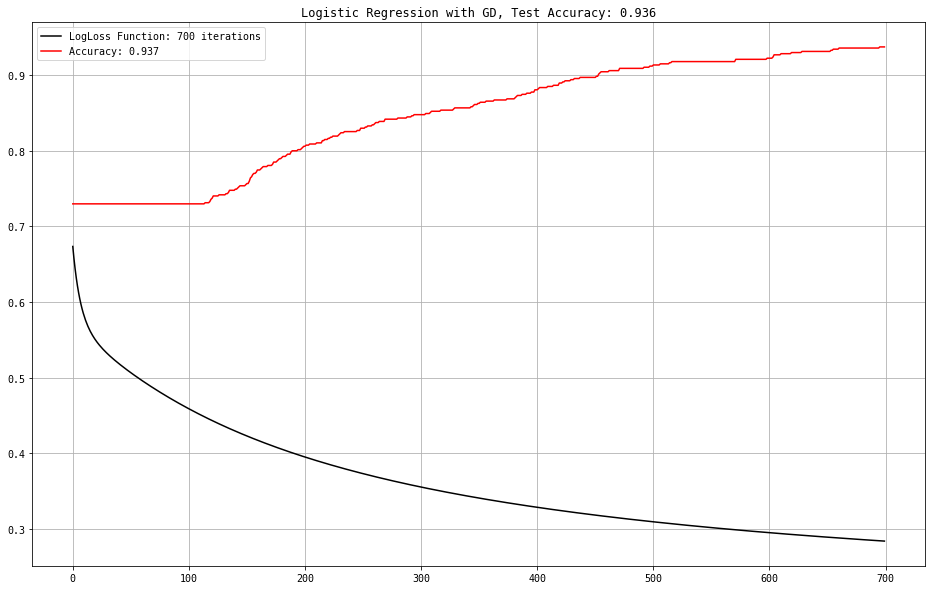

In [9]:
fig, ax = plt.subplots(figsize = (16,10),sharex=True,sharey=True,frameon = False)
ax.plot(losses, label=f'LogLoss Function: {iterate} iterations',color = 'black')
ax.plot(accuracy, label=f'Accuracy: {accuracy[-1]:.3}',color = 'red')
ax.set_title(f"Logistic Regression with GD, Test Accuracy: {test_accuracy:.3}")
plt.legend()
plt.grid()
plt.show()